In [1]:
import warnings
import torch
import math
import time
import os
import matplotlib.pyplot as plt
from itertools import cycle
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from torch.optim.lr_scheduler import _LRScheduler
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(device)

c:\Users\nou-z\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
from datasets import load_dataset
dataset = load_dataset("EleutherAI/wikitext_document_level", "wikitext-2-raw-v1", split="train")

In [3]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2") # Get the same tokenizer used for GPT-2


print("Vocabulary size:", tokenizer.n_vocab) # Vocabilary size is how many unique tokens the tokenizer can encode
print("End of text token:", tokenizer.eot_token) # End of text token is used to indicate the end of a text sequence
print("Example tokenization:", tokenizer.encode("Hello world!"))

# Convert entire dataset into a single string
# This dataset is small enough to fit into memory
# For larger datasets, you may need to use more 
# sophisticated methods to process the data.

all_text = ""
all_data = dataset["page"]
for example in all_data:
    all_text += "<page> "+ example + " </page>"

# Tokenize the entire text at once
tokenized_text = tokenizer.encode(all_text)


# We will create a function that generates a dataset of examples
# for the language model. The function will take in the number of
# examples to generate, the block size, and the test split.
# It will return the training and test datasets.
def get_dataset(num_examples, context_window_length, test_split=0.1):
    input_blocks = [] # List to store input sequences
    target_blocks = [] # List to store target sequences

    # Use a sliding window to create input/target sequences
    for i in range(0, len(tokenized_text), context_window_length + 1):
        block = tokenized_text[i:i+context_window_length+ 1]
        
        # Skip blocks that are too short
        if len(block) < context_window_length + 1:
            continue

        input_seq = block[:-1]  
        target_seq = block[1:]  

        input_blocks.append(input_seq)
        target_blocks.append(target_seq)
        
        # Stop if we have enough examples
        if len(input_blocks) >= num_examples:
            break

    # Convert to tensors for pytorch and move to gpu
    inputs = torch.tensor(input_blocks, dtype=torch.long).to(device)
    targets = torch.tensor(target_blocks, dtype=torch.long).to(device)

    # Calculate train/test split point
    split_idx = int(num_examples * (1 - test_split))

    # Split into train/test
    train_inputs = inputs[:split_idx]
    train_targets = targets[:split_idx]
    test_inputs = inputs[split_idx:]
    test_targets = targets[split_idx:]
    return train_inputs, train_targets, test_inputs, test_targets

# Get a small dataset
i, o, _, _ = get_dataset(2, 4, 0)
print("Input Shape", i.shape)
print("Output Shape", o.shape)
print("Input Example:")
print(i)
print("Output Example:")
print(o)

Vocabulary size: 50257
End of text token: 50256
Example tokenization: [15496, 995, 0]
Input Shape torch.Size([2, 4])
Output Shape torch.Size([2, 4])
Input Example:
tensor([[   27,  7700,    29,   220],
        [  569, 18354,  7496, 17740]])
Output Example:
tensor([[ 7700,    29,   220,   796],
        [18354,  7496, 17740,  6711]])


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# A simple configuration container
class GPTConfig:
    def __init__(
        self, 
        vocab_size,  # size of the vocabulary, from tokenizer, for gpt2 tokenizer it is 50257
        n_layer,   # number of transformer blocks
        n_head,    # number of attention heads for each transformer block
        n_embd,  # embedding dimension for each token
        seq_len,  # sequence length for the model - e.g. the "context window" 
    
    ):
        self.vocab_size = vocab_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        self.seq_len = seq_len
     
test_config = GPTConfig(
    vocab_size=tokenizer.n_vocab,
    n_layer=2,  
    n_head=3,
    n_embd=6,
    seq_len=4,
)

In [5]:
def get_position_encoding(seq_len, d, n=10000):
    """
    Computes the positional encoding matrix of shape (seq_len, d).
    
    Args:
        seq_len (int): Length of the sequence.
        d (int): Dimension of the embedding.
        n (float): The base for the exponential term (default 10000 in many Transformer implementations).
    
    Returns:
        torch.Tensor: A tensor of shape (seq_len, d) containing the positional encodings.
    """
    
    P = torch.zeros(seq_len, d).to(device)
    for pos in range(seq_len):
        for i in range(0, d // 2):
            P[pos, 2 * i] = math.sin(pos / (n ** ((2 * i) / d)))
            if i + 1 < d:
                P[pos, 2* i + 1] = math.cos(pos / (n ** ((2 * i) / d)))

    return P.unsqueeze(0)


# Example usage:
position_encoding = get_position_encoding(seq_len=test_config.seq_len, d=test_config.n_embd)
print("Position encoding shape:", position_encoding.shape)

Position encoding shape: torch.Size([1, 4, 6])


In [6]:
class SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Query weights - will transform input embeddings into queries
        self.Wk = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Key weights - will transform input embeddings into keys
        self.Wv = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Value weights - will transform input embeddings into values

    def forward(self, x):
        print("Attention input shape:", x.shape)
        print("")
        print("Query weights shape:", self.Wq.shape)
        print("Key weights shape:", self.Wk.shape)
        print("Value weights shape:", self.Wv.shape)
        queries = x @ self.Wq # Matrix multiplication to transform input embeddings into queries
        keys = x @ self.Wk # Matrix multiplication to transform input embeddings into keys
        values = x @ self.Wv # Matrix multiplication to transform input embeddings into values
        print("")
        print("Queries shape:", queries.shape)
        print("Keys shape:", keys.shape)
        print("Values shape:", values.shape)

        qkt = queries @ keys.transpose(-2, -1) # Calculate QK^T
        qkt_scaled = qkt / math.sqrt(queries.size(-1)) # Scale QK^T by the dimension of the keys
        qkt_softmax = F.softmax(qkt_scaled, dim=-1) # Apply softmax row-wise to get attention weights
        print("")
        print("QK^T shape:", qkt.shape)

        attn_output = qkt_softmax @ values # Multiply softmax(QK^T) by values
        print("")
        print("Attention output shape:", attn_output.shape)
        return attn_output 


In [7]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Query weights - will transform input embeddings into queries
        self.Wk = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Key weights - will transform input embeddings into keys
        self.Wv = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Value weights - will transform input embeddings into values

    def forward(self, x):
        seq_len = x.shape[1] # Get sequence length (number of tokens / context window length)
        queries = x @ self.Wq # Matrix multiplication to transform input embeddings into queries
        keys = x @ self.Wk    # Matrix multiplication to transform input embeddings into keys
        values = x @ self.Wv  # Matrix multiplication to transform input embeddings into values
        qkt = queries @ keys.transpose(-2, -1)  # Calculate QK^T
        qkt_scaled = qkt / math.sqrt(queries.size(-1))  # Scale QK^T by the dimension of the keys

        # MASKING
        # THIS IS THE ONLY DIFFERENCE, USE -inf FOR UPPER TRIANGLE MASK SO THAT SOFTMAX WILL BE 0
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1)
        causal_mask = causal_mask.masked_fill(causal_mask == 1, float('-inf'))  # Upper triangle masked with -inf 
        qkt_scaled = qkt_scaled + causal_mask # Add the mask to the scaled QK^T
        # END MASKING

        qkt_softmax = F.softmax(qkt_scaled, dim=-1) # Apply softmax row-wise to get attention weights, the -inf values will become 0 here
        attn_output = qkt_softmax @ values # Multiply softmax(QK^T) by values
        return attn_output

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn_heads = nn.ModuleList([
            CausalSelfAttention(config) for _ in range(config.n_head)
        ])  # Create n_head attention heads
        self.projection = nn.Linear(config.n_embd * config.n_head, config.n_embd).to(device) # Linear layer to project multi-head attention outputs

    def forward(self, x):
        head_outputs = [head(x) for head in self.attn_heads] # Get the output of each attention head
        multihead_output = torch.cat(head_outputs, dim=-1) # Concatenate the outputs
        return self.projection(multihead_output) # Project the concatenated outputs

In [9]:
class GPTBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.mha = MultiHeadAttention(config)
        self.ln1 = nn.LayerNorm(config.n_embd).to(device)
        self.ffn = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
        ).to(device)
        self.ln2 = nn.LayerNorm(config.n_embd).to(device)

    def forward(self, x):
        x = x + self.mha(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x


In [10]:
class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embedding = nn.Embedding(config.vocab_size, config.n_embd).to(device)
        self.position_encoding = get_position_encoding(config.seq_len, config.n_embd)
        self.blocks = nn.Sequential(*[GPTBlock(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd).to(device)
        self.head = nn.Linear(config.n_embd, config.vocab_size).to(device)
    
    def forward(self, x):
        x = self.token_embedding(x) + self.position_encoding
        x = self.blocks(x)
        x = self.ln_f(x)
        return self.head(x)
    

In [11]:
def ROC_curve_micro(pred_tensor, label_tensor):
    device=pred_tensor.device
    n_class=pred_tensor.size(1)
    one_hot_labels = F.one_hot(label_tensor, num_classes=n_class).to(device)
    is_positive = one_hot_labels
    is_negative =1-one_hot_labels
    fn_diff = -is_positive.flatten()
    fp_diff = is_negative.flatten()
    thresh_tensor = -pred_tensor.flatten()
    fn_denom = is_positive.sum()
    fp_denom = is_negative.sum()
    sorted_indices = torch.argsort(thresh_tensor)
    sorted_fp_cum = fp_diff[sorted_indices].cumsum(0) / fp_denom
    sorted_fn_cum = -fn_diff[sorted_indices].flip(0).cumsum(0).flip(0) / fn_denom

    sorted_thresh = thresh_tensor[sorted_indices]
    sorted_is_diff = sorted_thresh.diff() != 0
    sorted_fp_end = torch.cat([sorted_is_diff, torch.tensor([True],device=device)])
    sorted_fn_end = torch.cat([torch.tensor([True],device=device), sorted_is_diff])

    uniq_thresh = sorted_thresh[sorted_fp_end]
    uniq_fp_after = sorted_fp_cum[sorted_fp_end]
    uniq_fn_before = sorted_fn_cum[sorted_fn_end]

    FPR = torch.cat([torch.tensor([0.0],device=device), uniq_fp_after])
    FNR = torch.cat([uniq_fn_before, torch.tensor([0.0],device=device)])

    return {
        "FPR": FPR,
        "FNR": FNR,
        "TPR": 1 - FNR,
        "min(FPR,FNR)": torch.minimum(FPR, FNR),
        "min_constant": torch.cat([torch.tensor([-1],device=device), uniq_thresh]),
        "max_constant": torch.cat([uniq_thresh, torch.tensor([0],device=device)])
    }
def ROC_AUC_micro(pred_tensor, label_tensor):
    roc = ROC_curve_micro(pred_tensor, label_tensor)
    FPR_diff = roc["FPR"][1:]-roc["FPR"][:-1]   
    TPR_sum = roc["TPR"][1:]+roc["TPR"][:-1]
    return torch.sum(FPR_diff*TPR_sum/2.0)
#AUM 
def Proposed_AUM_micro(pred_tensor, label_tensor):

    roc = ROC_curve_micro(pred_tensor, label_tensor)
    min_FPR_FNR = roc["min(FPR,FNR)"][1:-1]
    constant_diff = roc["min_constant"][1:].diff()
    return torch.sum(min_FPR_FNR * constant_diff)

In [12]:
def ROC_curve_macro(pred_tensor, label_tensor):
    n_class=pred_tensor.size(1)
    one_hot_labels = F.one_hot(label_tensor, num_classes=n_class)
    is_positive = one_hot_labels
    is_negative =1-one_hot_labels
    fn_diff = -is_positive
    fp_diff = is_negative
    thresh_tensor = -pred_tensor
    fn_denom = is_positive.sum(dim=0).clamp(min=1)
    fp_denom = is_negative.sum(dim=0).clamp(min=1)
    sorted_indices = torch.argsort(thresh_tensor,dim=0)
    sorted_fp_cum = torch.div(torch.gather(fp_diff, dim=0, index=sorted_indices).cumsum(0), fp_denom)
    sorted_fn_cum = -torch.div(torch.gather(fn_diff, dim=0, index=sorted_indices).flip(0).cumsum(0).flip(0) , fn_denom)
    sorted_thresh = torch.gather(thresh_tensor, dim=0, index=sorted_indices)
    #Problem starts here 
    zeros_vec=torch.zeros(1,n_class)
    FPR = torch.cat([zeros_vec, sorted_fp_cum])
    FNR = torch.cat([sorted_fn_cum, zeros_vec])
    return {
        "FPR_all_classes": FPR,
        "FNR_all_classes": FNR,
        "TPR_all_classes": 1 - FNR,
        "min(FPR,FNR)": torch.minimum(FPR, FNR),
        "min_constant": torch.cat([-torch.ones(1,n_class), sorted_thresh]),
        "max_constant": torch.cat([sorted_thresh, zeros_vec])
    }

def ROC_AUC_macro(pred_tensor, label_tensor):
    roc = ROC_curve_macro(pred_tensor, label_tensor)
    FPR_diff = roc["FPR_all_classes"][1:,:]-roc["FPR_all_classes"][:-1,]
    TPR_sum = roc["TPR_all_classes"][1:,:]+roc["TPR_all_classes"][:-1,:]
    sum_FPR_TPR= torch.sum(FPR_diff*TPR_sum/2.0,dim=0)
    count_non_defined=(sum_FPR_TPR == 0).sum()
    if count_non_defined==pred_tensor.size(1):
        return 0
    return  sum_FPR_TPR.sum()/(pred_tensor.size(1)-count_non_defined)
def Proposed_AUM_macro(pred_tensor, label_tensor):

    roc = ROC_curve_macro(pred_tensor, label_tensor)
    min_FPR_FNR = roc["min(FPR,FNR)"][1:-1,:]
    constant_diff = roc["min_constant"][1:,:].diff(dim=0)
    sum_min= torch.sum(min_FPR_FNR * constant_diff,dim=0)
    count_non_defined=(sum_min== 0).sum()
    if count_non_defined==pred_tensor.size(1):
        return 0
    return  sum_min.sum()/(pred_tensor.size(1)-count_non_defined)

In [ ]:
batch_size = 10
sequence_len = 128
num_steps = 300
train_inputs, train_targets, _, _ = get_dataset(10, sequence_len, 0)
config = GPTConfig(
    vocab_size=tokenizer.n_vocab,
    n_layer=4,   # fewer layers for a quick demo
    n_head=4,
    n_embd=128,
    seq_len=sequence_len,
)

    
print("Original: ", tokenizer.decode(train_inputs[1].tolist())[:90])

Original:   runs parallel to the first game and follows the " Nameless " , a penal military unit serv


In [16]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(loaded_CE)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 13,707,857
Trainable parameters: 13,707,857


Step 2/1000, AUM_micro Loss: 0.45409220457077026, LR: 0.001
Step 3/1000, AUM_micro Loss: 0.40841758251190186, LR: 0.001
Step 4/1000, AUM_micro Loss: 0.36697402596473694, LR: 0.001
Step 5/1000, AUM_micro Loss: 0.3294964134693146, LR: 0.001
Step 6/1000, AUM_micro Loss: 0.2882547676563263, LR: 0.001
Step 7/1000, AUM_micro Loss: 0.24000276625156403, LR: 0.001
Step 8/1000, AUM_micro Loss: 0.20470930635929108, LR: 0.001
Step 9/1000, AUM_micro Loss: 0.16551318764686584, LR: 0.001
Step 10/1000, AUM_micro Loss: 0.13269056379795074, LR: 0.001
Step 11/1000, AUM_micro Loss: 0.10919132828712463, LR: 0.001
Step 12/1000, AUM_micro Loss: 0.08454707264900208, LR: 0.001
Step 13/1000, AUM_micro Loss: 0.06617487967014313, LR: 0.001
Step 14/1000, AUM_micro Loss: 0.04881587624549866, LR: 0.001
Step 15/1000, AUM_micro Loss: 0.03705509379506111, LR: 0.001
Step 16/1000, AUM_micro Loss: 0.028202300891280174, LR: 0.001
Step 17/1000, AUM_micro Loss: 0.020419776439666748, LR: 0.001
Step 18/1000, AUM_micro Loss: 0.

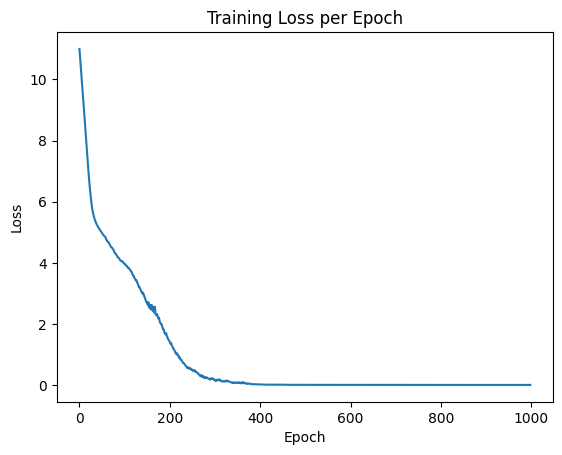

In [43]:
# Example config:
batch_size = 10
sequence_len = 128
num_steps = 1000
train_inputs, train_targets, _, _ = get_dataset(10, sequence_len, 0)
config = GPTConfig(
    vocab_size=tokenizer.n_vocab,
    n_layer=4,   # fewer layers for a quick demo
    n_head=4,
    n_embd=128,
    seq_len=sequence_len,
)

loss_dict={
    "AUM_micro": Proposed_AUM_micro,
    "AUM_macro": Proposed_AUM_macro,
    "Cross-entropy": F.cross_entropy
}

# Define Scheduler




# Training loop

for name,func in loss_dict.items():
    i = 1
    model = GPTModel(config)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.2, patience=20, min_lr=5e-6, threshold=1e-4)
    losses = []
    while i < num_steps:
        for j in range(0, len(train_inputs), batch_size):
            x = train_inputs[j:j+batch_size]
            y = train_targets[j:j+batch_size]

            # Forward pass
            logits = model(x)
            loss = func(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            losses.append(loss.item())
            
            optimizer.step()
            optimizer.zero_grad()
        
            

            loss = loss.item()
            scheduler.step(loss)
            lr = optimizer.param_groups[0]["lr"]
            
            print(f"Step {i+1}/{num_steps}, {name} Loss: {loss}, LR: {lr}")
            i += 1
    plt.clf()
    plt.plot(losses)
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig(f"{name} training_loss.png", dpi=300)
    torch.save(model, f"{name}_model_pretrain.pth")  

In [44]:
def inference(prompt, max_new_tokens,model):
    tokens = tokenizer.encode(prompt)
    for _ in range(max_new_tokens):
        num_tokens = len(tokens)
        tokens_padded = tokens + [tokenizer.eot_token] * (config.seq_len - num_tokens)
        tokens_padded = torch.tensor(tokens_padded).unsqueeze(0).to(device)
        logits = model(tokens_padded)
        predicted_token = torch.argmax(logits[0, num_tokens-1, :]).item()
        tokens.append(predicted_token)
    return tokenizer.decode(tokens)
    
print("Original: ", tokenizer.decode(train_inputs[2].tolist())[:90])

Original:   director Takeshi Ozawa . A large team of writers handled the script . The game 's opening


In [75]:
model_dict={}
loss_dict={
    "AUM_micro": Proposed_AUM_micro,
    "AUM_macro": Proposed_AUM_macro,
    "Cross-entropy": F.cross_entropy
}

for name , _ in loss_dict.items():
    model=torch.load(f"{name}_model_pretrain.pth")
    model_dict[name]=model
    print(f"Predicted for {name}:", inference(" director Takeshi Ozawa . A large team of", max_new_tokens=15,model=model))
print("Original: ", tokenizer.decode(train_inputs[2].tolist())[:110])


C:\Users\nou-z\AppData\Local\Temp\ipykernel_123164\3312788504.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load(f"{name}_model_pretrain.pth")


Predicted for AUM_micro:  director Takeshi Ozawa . A large team of III enemy III III III III III in III III III III III III III
Predicted for AUM_macro:  director Takeshi Ozawa . A large team of prim prim prim prim prim prim prim prim prim prim prim prim prim prim prim
Predicted for Cross-entropy:  director Takeshi Ozawa . A large team of writers handled the script . The game 's opening theme was sung by May
Original:   director Takeshi Ozawa . A large team of writers handled the script . The game 's opening theme was sung by M


In [67]:
train_inputs.view(-1, train_inputs.size(-1))
for name, loss_fn in loss_dict.items():
    model=model_dict[name]
    logits=model(train_inputs)
    print(f"AUC_micro for {name}:{ROC_AUC_micro(logits.view(-1, logits.size(-1)),train_inputs.view(-1))}")
    

AUC_micro for AUM_micro:0.9955000281333923
AUC_micro for AUM_macro:0.5537813305854797
AUC_micro for Cross-entropy:0.9738080501556396


In [70]:
for name, loss_fn in loss_dict.items():
    model=model_dict[name]
    logits=model(train_inputs)
    print(f"AUC_macro for {name}:{ROC_AUC_macro(logits.view(-1, logits.size(-1)),train_inputs.view(-1))}")


AUC_macro for AUM_micro:0.9969483613967896
AUC_macro for AUM_macro:0.997461199760437
AUC_macro for Cross-entropy:0.9978855848312378


In [72]:
train_inputs

tensor([[   27,  7700,    29,  ..., 27677,   837,   262],
        [ 4539, 10730,   284,  ..., 18354,  7496, 17740],
        [ 3437, 33687,  5303,  ...,   351,   262,  2478],
        ...,
        [ 6093, 31447,   326,  ...,   543,   389,  9387],
        [ 1936,  1180, 12608,  ...,   262,  4876,   837],
        [ 1431,   416,   511,  ...,  4632,   360,  5605]])